In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.show()
plt.close()
matplotlib.rcParams.update({"font.size": 16})
default_cycle_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
print(default_cycle_colors)

from cycler import cycler
import numpy as np

import glob
import os

from functools import partial

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

<Figure size 432x288 with 0 Axes>

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [2]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

In [3]:
import copy

In [4]:
import pandas as pd

In [5]:
import phenom

In [6]:
os.sys.path.append("/Users/sebastian.khan/personal/git/stk/ml/waveforms/oct2022/uncertainty")

In [7]:
# custom module
import collocation as col
import utils

In [8]:
import sympy
# sympy.init_printing()
x_sym, a_sym, om_rd = sympy.symbols('x_sym a_sym om_rd')

In [9]:
# custom pn module for inspiral
import pn

In [10]:
# gpr fitting
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, RationalQuadratic, Matern, DotProduct

# custom functions

In [11]:
def get_fdamp_from_q(q):
    """
    estimate ringdown damping frequency from mass-ratio `q`.
    """
    eta = phenom.eta_from_q(q)
    fin_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
    fdamp = phenom.remnant.fdamp(eta, 0, 0, fin_spin)
    return fdamp

In [12]:
def get_fring_from_q(q):
    """
    estimate ringdown frequency from mass-ratio `q`.
    """
    eta = phenom.eta_from_q(q)
    fin_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
    fring = phenom.remnant.fring(eta, 0, 0, fin_spin)
    return fring

# fit class

In [13]:
class ParameterSpaceFits(object):
    """
    collect together the results from the individual fits and then fit them using GPR
    """
    def __init__(self, wffs):
        
        self.wffs = wffs
        
        # the independent variable
        # if it were aligned spin it would be a (N, 3) matrix
        # where N is the number of waveforms and the columns
        # would be ['q', 'chi1', 'chi2']
        self.xs = np.array([wff.waveform.q for wff in self.wffs])
        
        # useful for setting length of loops
        self.num_collocation_points = {}
        for d in self.wffs[0].collocation_points.keys():
            self.num_collocation_points[d] = len(self.wffs[0].collocation_points[d])
            
        # ys: stores the targets for parameter space fits.
        # it has the same structure as rhs.
        # i.e. the keys are integers and correspond to the
        # derivative order
        # for each key the values are a list of length equal
        # to the number of collocation points
        ys = {}
        # signs: records the sign i.e. -ve or +ve for each data point
        # we need this is we use the log(abs()) transformation to be able
        # to recover the original sign of the data.
        signs = {}
        # loop over derivatives
        for d in self.wffs[0].cm.rhs.keys():
            ys[d] = []
            signs[d] = []
            # loop over collocation points
            for c in range(self.num_collocation_points[d]):
                t = np.array([wff.cm.rhs[d][c] for wff in self.wffs])
                ys[d].append(t)
                s = [np.sign(t_) for t_ in t][0] # assumption: take sign from first waveform
                signs[d].append(s)
        self.ys = ys
        self.signs = signs
        
    def compute_alphas(self):
        """
        sets the self.alphas attribute
        use this when you have multiple observations i.e. multiple mass-ratio x simulations
        for each collocation point we compute the standard deviation over observations
        and use this as a proxy for the uncertainty in that data point.
        for data points where we only have one observation we assume that their uncertainty
        is given by the median value of the distribution of standard deviations
        """
        alphas = {}
        for d in self.wffs[0].cm.rhs.keys():
            alphas[d] = []
            for c in range(self.num_collocation_points[d]):
                # create a dataframe so we can group by easily
                df=pd.DataFrame({'x':self.xs, 'y':self.ys[d][c]})
                # group by mass-ratio and compute standard deviation
                df2=df.groupby(by='x').std()
                df2=df2.rename(columns={'y':'alpha'})
                # remove nans (these are the cases were only one simulation exists)
                # and compute the median value of the distribution of stds
                median_std = np.median(df2['alpha'].values[~np.isnan(df2['alpha'].values)])

                # impute nans with median value
                # join back onto original dataframe so that we have a value of alpha
                # for every data point
                df3=pd.merge(df, df2.fillna(median_std), left_on='x', right_index=True).sort_index()
                alphas[d].append(df3['alpha'].values)
        self.alphas = alphas
        
    def fit(self, GaussianProcessRegressor_kwargs, log_abs_transform=True, use_estimate_alpha=True):
        """
        use_estimate_alpha: if this is true then will use an estimate for alpha based on the data
        """
        if use_estimate_alpha == True:
            assert hasattr(self, 'alphas'), "attribute alphas not set"
        GaussianProcessRegressor_kwargs = GaussianProcessRegressor_kwargs.copy()
        self.log_abs_transform = log_abs_transform
        # loop of self.ys and build a fit
        yhats = {}
        gprs = {}
        # loop over derivatives
        for d in self.ys.keys():
            # loop over collocation points
            yhats[d] = []
            gprs[d] = []
            for c in range(self.num_collocation_points[d]):
                x = self.xs
                y = self.ys[d][c]
                if self.log_abs_transform:
                    y = np.log(np.abs(y))
                if use_estimate_alpha == True:
                    GaussianProcessRegressor_kwargs.update({'alpha':self.alphas[d][c]})
                gpr = GaussianProcessRegressor(**GaussianProcessRegressor_kwargs).fit(x[:,np.newaxis], y)
                gprs[d].append(gpr)
                
        self.gprs = gprs
                
    def predict_sample(self, x, num_samples, random_state=1):
        mus = {}
        for d in self.gprs.keys():
            mus[d] = []
            for c in range(self.num_collocation_points[d]):
                mu = self.gprs[d][c].sample_y(x, num_samples, random_state=random_state)
                if self.log_abs_transform:
                    s = np.array(self.signs[d][c])
                    mu = s * np.exp(mu)
                mus[d].append(mu.T)
        return mus
    
    def predict_mean(self, x):
        mus = {}
        for d in self.gprs.keys():
            mus[d] = []
            for c in range(self.num_collocation_points[d]):
                mu = self.gprs[d][c].predict(x)
                if self.log_abs_transform:
                    s = np.array(self.signs[d][c])
                    mu = s * np.exp(mu)
                # we add a new axis in first position so that we get a shape (1, n) so that it is consistent with 
                # how we treat many samples which a shape (n_samples, n)
                mus[d].append(mu[np.newaxis, :])
                # mus[d].append([mu])
                # mus[d].append(mu)
        return mus

In [14]:
def model_full_phase(q, t, inspiral_model, merger_model, ringdown_model, t_ins=-300, t_m_erd=0, random_state=None, n_samples=1):
# def model_full_phase(q, t, inspiral_model, merger_model, ringdown_model, t_ins=-100, t_m_erd=0, random_state=None, n_samples=1):
    freq = model_full_freq(q, t, inspiral_model, merger_model, ringdown_model, t_ins, t_m_erd, random_state, n_samples)
    ifreq = [IUS(t, f) for f in freq]
    return np.array([ifreq_.antiderivative()(t) for ifreq_ in ifreq])

In [15]:
def model_full_freq(q, t, inspiral_model, merger_model, ringdown_model, t_ins=-300, t_m_erd=0, random_state=None, n_samples=1):
# def model_full_freq(q, t, inspiral_model, merger_model, ringdown_model, t_ins=-100, t_m_erd=0, random_state=None, n_samples=1):
    """
    n_samples is only used when you specify that you want to sample the model and the output shape is going to be (n_samples, n_time)
    if you want to compute the mean model (i.e. use the mean from the GP) then n_samples should be left at 1 and the output will be (1, n_time)
    """
    if random_state == None:
        random_state = np.random.randint(0, 1000000)
        
    y = np.zeros(shape=(n_samples, len(t)))
    
    mask = t < t_ins
    inspiral_times = t[mask]

    mask = (t >= t_ins) & (t < t_m_erd)
    merger_times = t[mask]

    mask = t >= t_m_erd
    ringdown_times = t[mask]

    # compute all inspirals
    pn_kwargs=dict(t=inspiral_times, tc=Tc, eta=phenom.eta_from_q(q), M=1)
    pn_residual = pn.TaylorT3_Omega_new(**pn_kwargs)
    # pn_residual = np.zeros_like(inspiral_times)
    y_ins = inspiral_model(q=q, t=inspiral_times, random_state=random_state, pn_residual=pn_residual, n_samples=n_samples) 

    y_merger = merger_model(q=q, t=merger_times, random_state=random_state, n_samples=n_samples)

    y_ringdown = ringdown_model(q=q, t=ringdown_times, random_state=random_state, n_samples=n_samples)

    return np.concatenate((y_ins, y_merger, y_ringdown), axis=1)

In [16]:
def rd_ansatz_log(t, a, b):
    return np.log(a) - t*b

def connect_rd(t0, y0, fdamp):
    """
    y0 == y(t0)
    this is just fixing the constant offset between the phenom model from peak amplitude
    to about t0=30M.
    We assume the slope is given by the approximately known damping frequency
    We assume exponential decay so it's linear in log-space
    """
    b = fdamp*2*np.pi
    log_a = np.log(y0) + b * t0
    return np.exp(log_a), b

In [17]:
def model_full_amp(q, t, inspiral_model, merger_model, early_ringdown_model, t_ins=-300, t_m_erd=0, t_erd_end=30, random_state=None, n_samples=1):
# def model_full_amp(q, t, inspiral_model, merger_model, early_ringdown_model, t_ins=-100, t_m_erd=0, t_erd_end=30, random_state=None, n_samples=1):
    if random_state == None:
        random_state = np.random.randint(0, 1000000)
        
    fdamp = get_fdamp_from_q(q)
        
    y = np.zeros(shape=(n_samples, len(t)))
    
    mask = t < t_ins
    inspiral_times = t[mask]

    mask = (t >= t_ins) & (t < t_m_erd)
    merger_times = t[mask]

    mask = (t >= t_m_erd) & (t < t_erd_end)
    ringdown_times = t[mask]
    
    mask = t >= t_erd_end
    late_ringdown_times = t[mask]

    # compute all inspirals
    pn_kwargs=dict(t=inspiral_times, tc=Tc, eta=phenom.eta_from_q(q), M=1)
    pn_residual = np.abs(pn.Hhat22_T3(**pn_kwargs))
    # pn_residual = np.zeros_like(inspiral_times)
    y_ins = inspiral_model(q=q, t=inspiral_times, random_state=random_state, pn_residual=pn_residual, n_samples=n_samples) 
    
    # compute all mergers
    y_merger = merger_model(q=q, t=merger_times, random_state=random_state, n_samples=n_samples)
    
    # compute all early ringdowns
    y_early_ringdown = early_ringdown_model(q=q, t=ringdown_times, random_state=random_state, n_samples=n_samples)
    
    # compute all late ringdowns
    # note that the `b`'s only depend on mass-ratio
    # so we only have one of them and not n_samples of them
    
    # this is the value of the final point
    # which we use to connect the exponential ringdown
    y0 = early_ringdown_model(q=q, t=t_erd_end, random_state=random_state, n_samples=n_samples)
    y0 = y0[np.newaxis, :]
    
    a, b = connect_rd(t0=t_erd_end, y0=y0.T, fdamp=fdamp)

    y_late_ringdown = np.exp(rd_ansatz_log(late_ringdown_times, a, b))
    
    return np.concatenate((y_ins, y_merger, y_early_ringdown, y_late_ringdown), axis=1)

In [18]:
def model_full_strain(q, t, amp_model_kwargs, phase_model_kwargs, n_samples=1):
    amp = model_full_amp(q, t, n_samples=n_samples, **amp_model_kwargs)
    phase = model_full_phase(q, t, n_samples=n_samples, **phase_model_kwargs)
    
    h = amp * np.exp(-1.j * phase)
    
    return h

In [19]:
# https://stackoverflow.com/a/31365136/12840171
# need to use cl
import cloudpickle

import os
import glob

In [20]:
# this loads the "models" pickle files
# these are the objects that are ready to be called to generate samples for the model
input_dir = "model_050123"
model_filenames = glob.glob(os.path.join(input_dir, "models*.cpkl"))
print(model_filenames)

models = {}
for model_filename in model_filenames:
    print(f"loading model: {model_filename}")
    k = model_filename.split("/")[-1].split(".")[0].split("models_")[-1]
    print(f"k: {k}")
    with open(model_filename, 'rb') as my_file:
        models[k] = cloudpickle.load(my_file)

['model_050123/models_amp_ringdown.cpkl', 'model_050123/models_freq_merger.cpkl', 'model_050123/models_freq_ringdown.cpkl', 'model_050123/models_amp_merger.cpkl', 'model_050123/models_freq_inspiral.cpkl', 'model_050123/models_amp_inspiral.cpkl']
loading model: model_050123/models_amp_ringdown.cpkl
k: amp_ringdown
loading model: model_050123/models_freq_merger.cpkl
k: freq_merger
loading model: model_050123/models_freq_ringdown.cpkl
k: freq_ringdown
loading model: model_050123/models_amp_merger.cpkl
k: amp_merger
loading model: model_050123/models_freq_inspiral.cpkl
k: freq_inspiral
loading model: model_050123/models_amp_inspiral.cpkl
k: amp_inspiral


In [21]:
# this loads the "mean_models" pickle files
# these are the objects that are ready to be called to generate the mean prediction of the model

input_dir = "model_050123"
model_filenames = glob.glob(os.path.join(input_dir, "mean_models*.cpkl"))
print(model_filenames)

mean_models = {}
for model_filename in model_filenames:
    print(f"loading model: {model_filename}")
    k = model_filename.split("/")[-1].split(".")[0].split("mean_models_")[-1]
    print(f"k: {k}")
    with open(model_filename, 'rb') as my_file:
        mean_models[k] = cloudpickle.load(my_file)

['model_050123/mean_models_freq_inspiral.cpkl', 'model_050123/mean_models_amp_merger.cpkl', 'model_050123/mean_models_amp_inspiral.cpkl', 'model_050123/mean_models_freq_merger.cpkl', 'model_050123/mean_models_freq_ringdown.cpkl', 'model_050123/mean_models_amp_ringdown.cpkl']
loading model: model_050123/mean_models_freq_inspiral.cpkl
k: freq_inspiral
loading model: model_050123/mean_models_amp_merger.cpkl
k: amp_merger
loading model: model_050123/mean_models_amp_inspiral.cpkl
k: amp_inspiral
loading model: model_050123/mean_models_freq_merger.cpkl
k: freq_merger
loading model: model_050123/mean_models_freq_ringdown.cpkl
k: freq_ringdown
loading model: model_050123/mean_models_amp_ringdown.cpkl
k: amp_ringdown


In [22]:
mean_models['freq_inspiral']

functools.partial(<function mean_model_base at 0x159e9c790>, collocation_points={0: [-700, -500, -300]}, ansatz=x_sym**(-1.25) + x_sym**(-1.125) + x_sym**(-1.0), gpr_model=<__main__.ParameterSpaceFits object at 0x159ec8940>)

In [23]:
t = np.arange(-600, 100, 1)
q = 1
Tc=1000

In [24]:
yhat = model_full_amp(q, t, inspiral_model=mean_models['amp_inspiral'], merger_model=mean_models['amp_merger'], early_ringdown_model=mean_models['amp_ringdown'], t_ins=-300, t_m_erd=0, t_erd_end=30, random_state=None, n_samples=1)

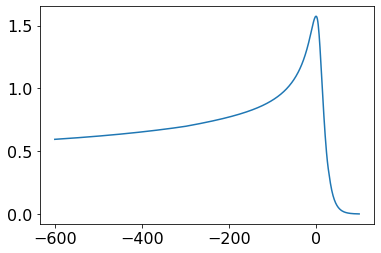

In [25]:
plt.plot(t, yhat[0])

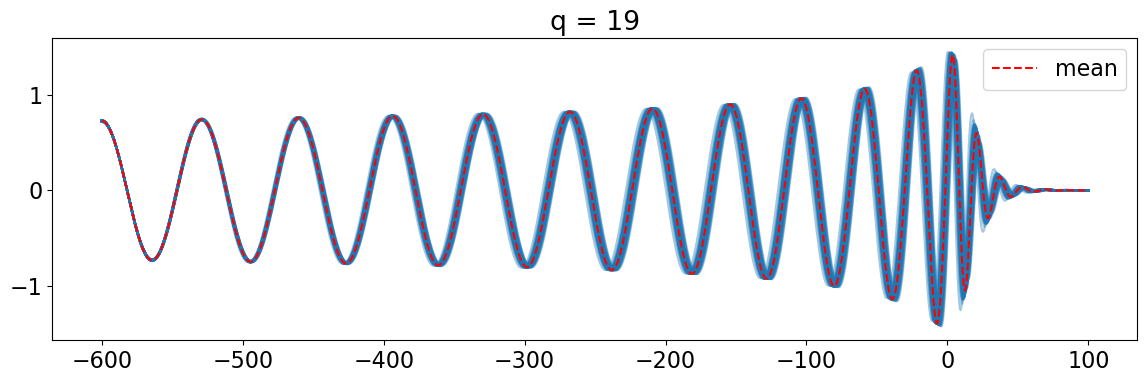

In [26]:
amp_model_kwargs = dict(inspiral_model=models['amp_inspiral'], merger_model=models['amp_merger'], early_ringdown_model=models['amp_ringdown'])
phase_model_kwargs = dict(inspiral_model=models['freq_inspiral'], merger_model=models['freq_merger'], ringdown_model=models['freq_ringdown'])

mean_amp_model_kwargs = dict(inspiral_model=mean_models['amp_inspiral'], merger_model=mean_models['amp_merger'], early_ringdown_model=mean_models['amp_ringdown'])
mean_phase_model_kwargs = dict(inspiral_model=mean_models['freq_inspiral'], merger_model=mean_models['freq_merger'], ringdown_model=mean_models['freq_ringdown'])


n_samples = 100
q = 19
times = np.arange(-600, 100, 0.1)
yys = model_full_strain(q, times, amp_model_kwargs, phase_model_kwargs, n_samples=n_samples)
yys = yys.real

yys_mean = np.array(model_full_strain(q, times, mean_amp_model_kwargs, mean_phase_model_kwargs))[0]
yys_mean = yys_mean.real



plt.figure(figsize=(14, 4), dpi=100)
plt.plot(times, yys.T, c='C0', alpha=0.4);
plt.plot(times, yys_mean, c='r', ls='--', label='mean');
plt.title(f"q = {q}")
plt.legend()
plt.show()
plt.close()

# load data

In [27]:
catalogue_dir = "/Users/sebastian.khan/personal/data/non_spinning_catalogue_dec_2022"

In [28]:
df = pd.read_csv(os.path.join(catalogue_dir, 'metadata.csv'))

In [29]:
times = np.load(os.path.join(catalogue_dir, 'times.npy'))

In [30]:
strains = np.load(os.path.join(catalogue_dir, 'strains.npy'))

In [31]:
strains.shape

(55, 8620)

In [32]:
df.shape

(55, 6)

In [33]:
amps=np.array([np.abs(strain) for strain in strains])
phases=np.array([np.unwrap(np.angle(strain)) for strain in strains])
freqs=np.array([IUS(times, phase).derivative()(times) for phase in phases])

In [34]:
amps = amps.T / phenom.eta_from_q(df['q'].values)
amps = amps.T

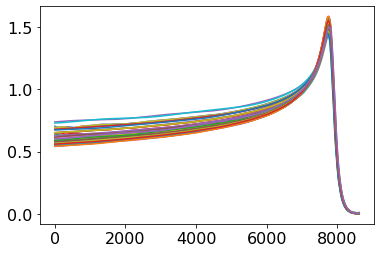

In [35]:
plt.plot(amps.T);

In [36]:
df

name      q     fring     fdamp  duration  t_final
0    q18a0a0c025_96_fine  18.00  0.063334  0.014140    1020.0    465.8
1          q4a0_T_96_384   4.00  0.074330  0.014004    2202.1    229.5
2    q8a0a0_T_96_504n512   8.00  0.067697  0.014104     953.1    430.4
3     q8a0a0c05_T_80_420   8.00  0.067697  0.014104     941.9    259.8
4      q10c25e_T_112_448  10.00  0.066184  0.014119    1157.7    121.6
5          q4a0_T_80_320   4.00  0.074330  0.014004    2199.5    689.1
6        q18a0a0c025_144  18.00  0.063334  0.014140    1028.3     88.8
7   q8a0a0_T_112_588n768   8.00  0.067697  0.014104     957.9    207.8
8        q18a0a0c025_120  18.00  0.063334  0.014140    1027.5    174.7
9         q4a0_T_112_448   4.00  0.074330  0.014004    2202.5    151.8
10     SXS_BBH_0107_Res3   5.00  0.071862  0.014048    7440.1    449.9
11     SXS_BBH_0167_Res5   4.00  0.074330  0.014004    3115.7    404.1
12     SXS_BBH_0107_Res5   5.00  0.071862  0.014048    7465.5    451.5
13     SXS_BBH_0107_Res4   5.00  0.071862  0.014048    7457.2    449.8
14     SXS_BBH_0167_Res3   4.00  0.074330  0.014004    2874.0    403.8
15     SXS_BBH_0169_Res4   2.00  0.083149  0.013774    3458.2    406.7
16     SXS_BBH_0169_Res5   2.00  0.083149  0.013774    3468.3    406.6
17     SXS_BBH_0169_Res3   2.00  0.083149  0.013774    3088.2    406.7
18     SXS_BBH_0180_Res3   1.00  0.088087  0.013596    9359.5    236.6
19     SXS_BBH_0303_Res3  10.00  0.066184  0.014119    3397.6    498.9
20     SXS_BBH_0180_Res2   1.00  0.088087  0.013596    9354.6    236.8
21     SXS_BBH_0303_Res4  10.00  0.066184  0.014119    3433.2    499.1
22     SXS_BBH_0180_Res4   1.00  0.088087  0.013596    9270.5    236.4
23     SXS_BBH_0303_Res5  10.00  0.066184  0.014119    3461.4    499.7
24     RIT-BBH-0416-n140   7.00  0.068739  0.014092    2362.1    363.1
25     RIT-BBH-0084-n100   1.18  0.087761  0.013608    1602.1    396.2
26     RIT-BBH-0152-n120   5.00  0.071862  0.014048    4000.5    557.5
27    RIT-eBBH-1090-n100   1.00  0.088087  0.013596    1493.9    362.0
28    RIT-eBBH-1133-n100   4.00  0.074330  0.014004    2143.1    712.8
29    RIT-eBBH-1241-n100   1.33  0.087138  0.013633    1520.6    335.3
30     RIT-BBH-0942-n120  15.00  0.064066  0.014135    1162.8    330.2
31     RIT-BBH-0112-n100   1.00  0.088087  0.013596   16963.4    419.5
32     RIT-BBH-0139-n140   2.41  0.080777  0.013847    2736.9    423.5
33     RIT-BBH-0373-n140  15.00  0.064066  0.014135    2725.0    437.6
34     RIT-BBH-0792-n120  32.00  0.061687  0.014149    1558.3    191.2
35     RIT-BBH-0090-n100   6.00  0.070079  0.014075    1746.7    392.9
36     RIT-BBH-1020-n144   1.82  0.084262  0.013737    1368.2    249.8
37    RIT-eBBH-1200-n100   2.00  0.083149  0.013774    1637.8    318.1
38     RIT-BBH-0978-n144  10.00  0.066184  0.014119    1963.0    393.4
39     RIT-BBH-1025-n100  32.00  0.061687  0.014149    1474.0    240.2
40     RIT-BBH-0957-n084  15.00  0.064066  0.014135    1038.4    363.1
41                GT0379   2.20  0.081956  0.013812     936.3    616.9
42                GT0378   2.05  0.082845  0.013784     915.7    637.3
43                GT0757   2.25  0.081668  0.013820    1429.1    420.0
44                GT0380   2.35  0.081105  0.013837     957.9    595.3
45                GT0454   4.00  0.074330  0.014004    1855.1    495.1
46                GT0898   1.20  0.087693  0.013611    1793.9    286.8
47                GT0446   2.00  0.083149  0.013774    1378.6    470.3
48                GT0453   3.00  0.077907  0.013924    1599.7    549.9
49                GT0727   1.75  0.084699  0.013722    1330.0    418.7
50                GT0477   1.50  0.086221  0.013667    1286.6    361.9
51                GT0738   1.25  0.087500  0.013619    1252.6    395.9
52                GT0577   5.00  0.071862  0.014048    1281.6    574.2
53                GT0565   2.50  0.080296  0.013861    1484.2    465.0
54                GT0604   6.00  0.070079  0.014075    1496.1    460.8

In [37]:
plt.figure(figsize=(14, 4))
plt.hist(df['q'], bins=50, histtype='step', lw=3)
plt.xlabel("mass-ratio");
plt.title("distribution of mass-ratio in catalogue")
plt.grid()

Text(0.5, 1.0, 'q18a0a0c025_96_fine')

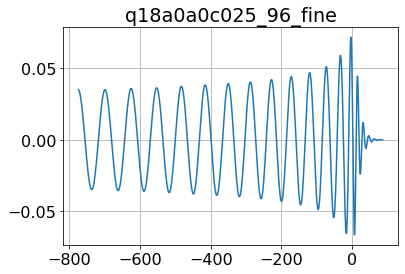

In [38]:
plt.plot(times, strains[0].real)
plt.grid()
plt.title(df.iloc[0]['name'])

# example comparison

In [39]:
model_full_strain(q, times, mean_amp_model_kwargs, mean_phase_model_kwargs).shape

(1, 8620)

In [40]:
yys_mean = np.array(model_full_strain(18, times, mean_amp_model_kwargs, mean_phase_model_kwargs))[0]

Text(0.5, 1.0, 'q18a0a0c025_144')

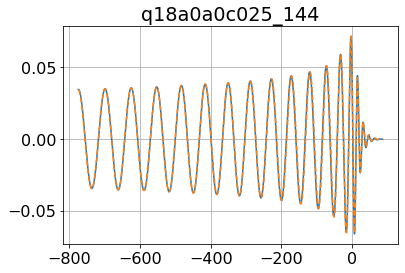

In [41]:

i=6
plt.plot(times, strains[i].real)



yys_mean = np.array(model_full_strain(df.iloc[i]['q'], times, mean_amp_model_kwargs, mean_phase_model_kwargs))[0]

plt.plot(times, yys_mean.real * phenom.eta_from_q(df.iloc[i]['q']), ls='--')

plt.grid()
plt.title(df.iloc[i]['name'])

# plt.xlim(-100,100)

# build pycbc interface

In [42]:
import lal

In [43]:
import pycbc.waveform

In [44]:
import pycbc.types

In [45]:
import pycbc.filter
import pycbc.psd


In [46]:
amp_model_kwargs = dict(inspiral_model=models['amp_inspiral'], merger_model=models['amp_merger'], early_ringdown_model=models['amp_ringdown'])
phase_model_kwargs = dict(inspiral_model=models['freq_inspiral'], merger_model=models['freq_merger'], ringdown_model=models['freq_ringdown'])

mean_amp_model_kwargs = dict(inspiral_model=mean_models['amp_inspiral'], merger_model=mean_models['amp_merger'], early_ringdown_model=mean_models['amp_ringdown'])
mean_phase_model_kwargs = dict(inspiral_model=mean_models['freq_inspiral'], merger_model=mean_models['freq_merger'], ringdown_model=mean_models['freq_ringdown'])

In [47]:
def get_nr_strain(strain, times, M, distance=1e6 * lal.PC_SI):
    eta = phenom.eta_from_q(q)
    dt_M = times[1] - times[0]
    delta_t = phenom.MtoS(dt_M, M)
    
    epoch = phenom.MtoS(times[0], M)
    h = strain * utils.td_amp_scale(60, 1e6 * lal.PC_SI)*lal.SpinWeightedSphericalHarmonic(0,0,-2,2,2)
    hp = h.real
    hc = h.imag
    hp = pycbc.types.TimeSeries(hp, delta_t=delta_t, epoch=epoch)
    hc = pycbc.types.TimeSeries(hc, delta_t=delta_t, epoch=epoch)
    return hp, hc

In [48]:
def gen_model(q, times, M, n_samples=-1, distance=1e6 * lal.PC_SI):
    """
    if n_samples == -1 then generates the mean
    otherwise samples
    """
    eta = phenom.eta_from_q(q)
    dt_M = times[1] - times[0]
    delta_t = phenom.MtoS(dt_M, M)
    
    epoch = phenom.MtoS(times[0], M)
    
    if n_samples == -1:
        h = model_full_strain(q, times, mean_amp_model_kwargs, mean_phase_model_kwargs)
    else:
        h = model_full_strain(q, times, amp_model_kwargs, phase_model_kwargs, n_samples=n_samples)
        
    h = h*eta
    h = h * utils.td_amp_scale(M, distance) * lal.SpinWeightedSphericalHarmonic(0,0,-2,2,2)
    
    hp = h.real
    hc = h.imag
    
    if n_samples == -1:
        hp = pycbc.types.TimeSeries(hp[0], delta_t=delta_t, epoch=epoch)
        hc = pycbc.types.TimeSeries(hc[0], delta_t=delta_t, epoch=epoch)
    else:
        hp = [pycbc.types.TimeSeries(hp_, delta_t=delta_t, epoch=epoch) for hp_ in hp]
        hc = [pycbc.types.TimeSeries(hc_, delta_t=delta_t, epoch=epoch) for hc_ in hc]
    
    return hp, hc

In [475]:
times_sec = phenom.MtoS(times, 60)

In [476]:
delta_t = times_sec[1]-times_sec[0]
delta_t

2.9552946153227344e-05

In [477]:
1/delta_t

33837.57391953947

In [478]:
(1/delta_t)/2

16918.786959769735

In [479]:
1/(1/2048)

2048.0

In [480]:
1/(1/2048)/2

1024.0

In [481]:
# df_test = df.query('(q>1 and q<2) or (q>2 and q<=4) or (q>=7 and q<10)')

In [482]:
# df_test

In [583]:
# i = 6
# i = 9
# i = 18
# i = 31
# i = 22
# i = 11
i = 24
# i=39
# i=34
# i = 54

# i = 12
# i = 13
# i = 10


# i=8
# i = 22
# i = 52
# i = 30
# i = 7

m_total = 60
n_samples = 100


i = 6
q = df.iloc[i]['q']
# q = 18

hm_p, hm_c = gen_model(q, times, m_total, -1)
hs_p, hs_c = gen_model(q, times, m_total, n_samples)

In [584]:
df.iloc[[i]]

name     q     fring    fdamp  duration  t_final
6  q18a0a0c025_144  18.0  0.063334  0.01414    1028.3     88.8

In [585]:
times[0]

-775.0

In [586]:
def get_start_frequency_for_model(q, times, m_total):
    # we just need the first few time points to get the start frequency
    hp, hc = gen_model(q, times[:10], m_total, -1)
    return -pycbc.waveform.utils.frequency_from_polarizations(hp, hc).numpy()[0]

In [587]:
f_lower = get_start_frequency_for_model(q, times, 100)
f_lower = np.around(f_lower, 5)
f_lower

26.47481

In [588]:
times

array([-775. , -774.9, -774.8, ...,   86.7,   86.8,   86.9])

In [589]:
# pycbc.types.TimeSeries(strains[0].real, )

In [590]:
df.query('q == 4')

name    q    fring     fdamp  duration  t_final
1        q4a0_T_96_384  4.0  0.07433  0.014004    2202.1    229.5
5        q4a0_T_80_320  4.0  0.07433  0.014004    2199.5    689.1
9       q4a0_T_112_448  4.0  0.07433  0.014004    2202.5    151.8
11   SXS_BBH_0167_Res5  4.0  0.07433  0.014004    3115.7    404.1
14   SXS_BBH_0167_Res3  4.0  0.07433  0.014004    2874.0    403.8
28  RIT-eBBH-1133-n100  4.0  0.07433  0.014004    2143.1    712.8
45              GT0454  4.0  0.07433  0.014004    1855.1    495.1

In [591]:
df

name      q     fring     fdamp  duration  t_final
0    q18a0a0c025_96_fine  18.00  0.063334  0.014140    1020.0    465.8
1          q4a0_T_96_384   4.00  0.074330  0.014004    2202.1    229.5
2    q8a0a0_T_96_504n512   8.00  0.067697  0.014104     953.1    430.4
3     q8a0a0c05_T_80_420   8.00  0.067697  0.014104     941.9    259.8
4      q10c25e_T_112_448  10.00  0.066184  0.014119    1157.7    121.6
5          q4a0_T_80_320   4.00  0.074330  0.014004    2199.5    689.1
6        q18a0a0c025_144  18.00  0.063334  0.014140    1028.3     88.8
7   q8a0a0_T_112_588n768   8.00  0.067697  0.014104     957.9    207.8
8        q18a0a0c025_120  18.00  0.063334  0.014140    1027.5    174.7
9         q4a0_T_112_448   4.00  0.074330  0.014004    2202.5    151.8
10     SXS_BBH_0107_Res3   5.00  0.071862  0.014048    7440.1    449.9
11     SXS_BBH_0167_Res5   4.00  0.074330  0.014004    3115.7    404.1
12     SXS_BBH_0107_Res5   5.00  0.071862  0.014048    7465.5    451.5
13     SXS_BBH_0107_Res4   5.00  0.071862  0.014048    7457.2    449.8
14     SXS_BBH_0167_Res3   4.00  0.074330  0.014004    2874.0    403.8
15     SXS_BBH_0169_Res4   2.00  0.083149  0.013774    3458.2    406.7
16     SXS_BBH_0169_Res5   2.00  0.083149  0.013774    3468.3    406.6
17     SXS_BBH_0169_Res3   2.00  0.083149  0.013774    3088.2    406.7
18     SXS_BBH_0180_Res3   1.00  0.088087  0.013596    9359.5    236.6
19     SXS_BBH_0303_Res3  10.00  0.066184  0.014119    3397.6    498.9
20     SXS_BBH_0180_Res2   1.00  0.088087  0.013596    9354.6    236.8
21     SXS_BBH_0303_Res4  10.00  0.066184  0.014119    3433.2    499.1
22     SXS_BBH_0180_Res4   1.00  0.088087  0.013596    9270.5    236.4
23     SXS_BBH_0303_Res5  10.00  0.066184  0.014119    3461.4    499.7
24     RIT-BBH-0416-n140   7.00  0.068739  0.014092    2362.1    363.1
25     RIT-BBH-0084-n100   1.18  0.087761  0.013608    1602.1    396.2
26     RIT-BBH-0152-n120   5.00  0.071862  0.014048    4000.5    557.5
27    RIT-eBBH-1090-n100   1.00  0.088087  0.013596    1493.9    362.0
28    RIT-eBBH-1133-n100   4.00  0.074330  0.014004    2143.1    712.8
29    RIT-eBBH-1241-n100   1.33  0.087138  0.013633    1520.6    335.3
30     RIT-BBH-0942-n120  15.00  0.064066  0.014135    1162.8    330.2
31     RIT-BBH-0112-n100   1.00  0.088087  0.013596   16963.4    419.5
32     RIT-BBH-0139-n140   2.41  0.080777  0.013847    2736.9    423.5
33     RIT-BBH-0373-n140  15.00  0.064066  0.014135    2725.0    437.6
34     RIT-BBH-0792-n120  32.00  0.061687  0.014149    1558.3    191.2
35     RIT-BBH-0090-n100   6.00  0.070079  0.014075    1746.7    392.9
36     RIT-BBH-1020-n144   1.82  0.084262  0.013737    1368.2    249.8
37    RIT-eBBH-1200-n100   2.00  0.083149  0.013774    1637.8    318.1
38     RIT-BBH-0978-n144  10.00  0.066184  0.014119    1963.0    393.4
39     RIT-BBH-1025-n100  32.00  0.061687  0.014149    1474.0    240.2
40     RIT-BBH-0957-n084  15.00  0.064066  0.014135    1038.4    363.1
41                GT0379   2.20  0.081956  0.013812     936.3    616.9
42                GT0378   2.05  0.082845  0.013784     915.7    637.3
43                GT0757   2.25  0.081668  0.013820    1429.1    420.0
44                GT0380   2.35  0.081105  0.013837     957.9    595.3
45                GT0454   4.00  0.074330  0.014004    1855.1    495.1
46                GT0898   1.20  0.087693  0.013611    1793.9    286.8
47                GT0446   2.00  0.083149  0.013774    1378.6    470.3
48                GT0453   3.00  0.077907  0.013924    1599.7    549.9
49                GT0727   1.75  0.084699  0.013722    1330.0    418.7
50                GT0477   1.50  0.086221  0.013667    1286.6    361.9
51                GT0738   1.25  0.087500  0.013619    1252.6    395.9
52                GT0577   5.00  0.071862  0.014048    1281.6    574.2
53                GT0565   2.50  0.080296  0.013861    1484.2    465.0
54                GT0604   6.00  0.070079  0.014075    1496.1    460.8

In [592]:
df.iloc[i]['q']

18.0

In [593]:
m1,m2=phenom.m1_m2_M_q(m_total, q)
m1,m2

(56.8421052631579, 3.1578947368421053)

In [594]:
# hp, hc = pycbc.waveform.get_td_waveform(approximant='SEOBNRv4', mass1=m1, mass2=m2, f_lower=15, delta_t=delta_t)
hp, hc = pycbc.waveform.get_td_waveform(approximant='IMRPhenomD', mass1=m1, mass2=m2, f_lower=15, delta_t=delta_t)

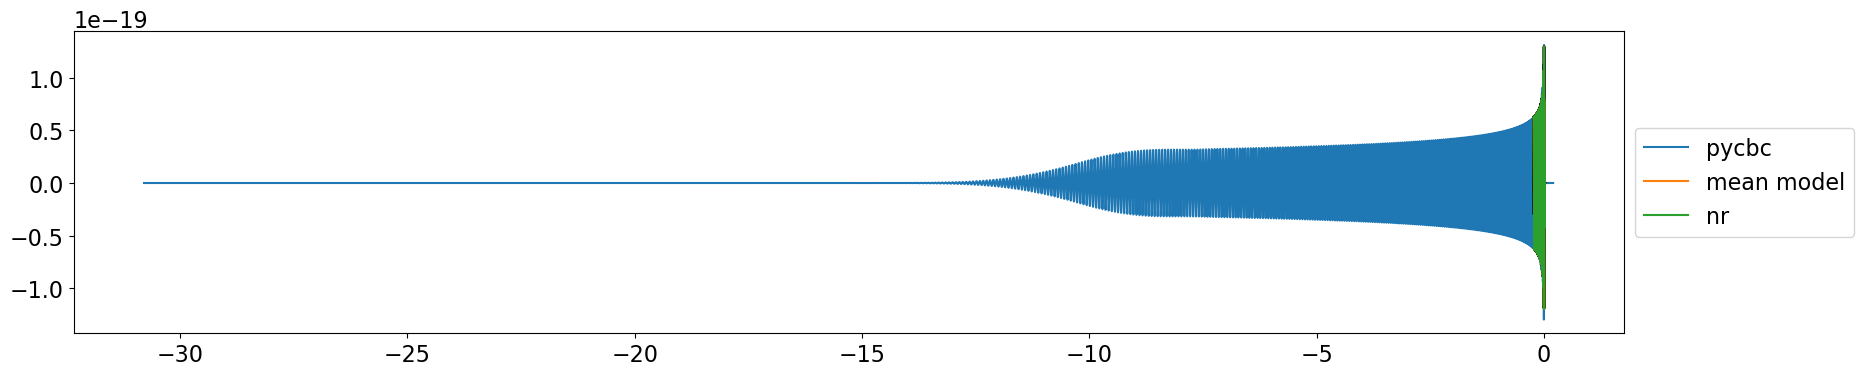

In [595]:
plt.figure(figsize=(20, 4), dpi=100)

plt.plot(hp.sample_times, hp, label='pycbc')


for hs_p_ in hs_p:
    plt.plot(hs_p_.sample_times, hs_p_, c='k', alpha=0.1)

plt.plot(hm_p.sample_times, hm_p, label='mean model')


hp_nr, hc_nr = get_nr_strain(strains[i], times, m_total)
# hp_nr, hc_nr = pycbc.waveform.get_td_waveform(approximant='IMRPhenomD', mass1=m1, mass2=m2, f_lower=15, delta_t=delta_t)
plt.plot(hp_nr.sample_times, hp_nr, label='nr')

# plt.xlim(-0.1,0.03)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [596]:
hp.delta_t

2.9552946153227347e-05

In [597]:
hp_nr.delta_t

2.955294615324672e-05

In [598]:
delta_t

2.9552946153227344e-05

In [599]:
def compute_match(h1, h2, f_low):
    # Resize the waveforms to the same length
    tlen = max(len(h1), len(h2))
    h1.resize(tlen)
    h2.resize(tlen)

    # Generate the aLIGO ZDHP PSD
    delta_f = 1.0 / h1.duration
    flen = tlen//2 + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_low)

    # Note: This takes a while the first time as an FFT plan is generated
    # subsequent calls are much faster.
    m, _ = pycbc.filter.match(h1, h2, psd=psd, low_frequency_cutoff=f_low)
    return m

In [600]:
compute_match(hp, hp_nr, f_lower*2)

0.9860373883609864

In [601]:
compute_match(hm_p, hp_nr, f_lower*2)

0.999397815493115

In [602]:
compute_match(hm_p, hp, f_lower*2)

0.9838727995501452

In [603]:
hm_p_tilde = hm_p.to_frequencyseries()
hp_tilde = hp.to_frequencyseries()
hp_nr_tilde = hp_nr.to_frequencyseries()

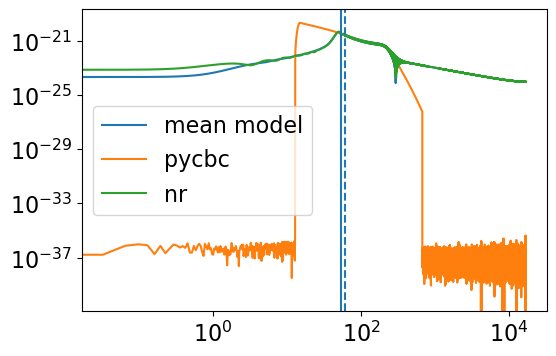

In [604]:
plt.figure(dpi=100)
plt.plot(hm_p_tilde.sample_frequencies, np.abs(hm_p_tilde), label='mean model')
plt.plot(hp_tilde.sample_frequencies, np.abs(hp_tilde), label='pycbc')
plt.plot(hp_nr_tilde.sample_frequencies, np.abs(hp_nr_tilde), label='nr')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.axvline(f_lower*2)
plt.axvline(60, ls='--')

In [605]:
h1, h2 = pycbc.waveform.utils.coalign_waveforms(hm_p, hp_nr, low_frequency_cutoff=60)
h3, _ = pycbc.waveform.utils.coalign_waveforms(hp, hp_nr, low_frequency_cutoff=60)

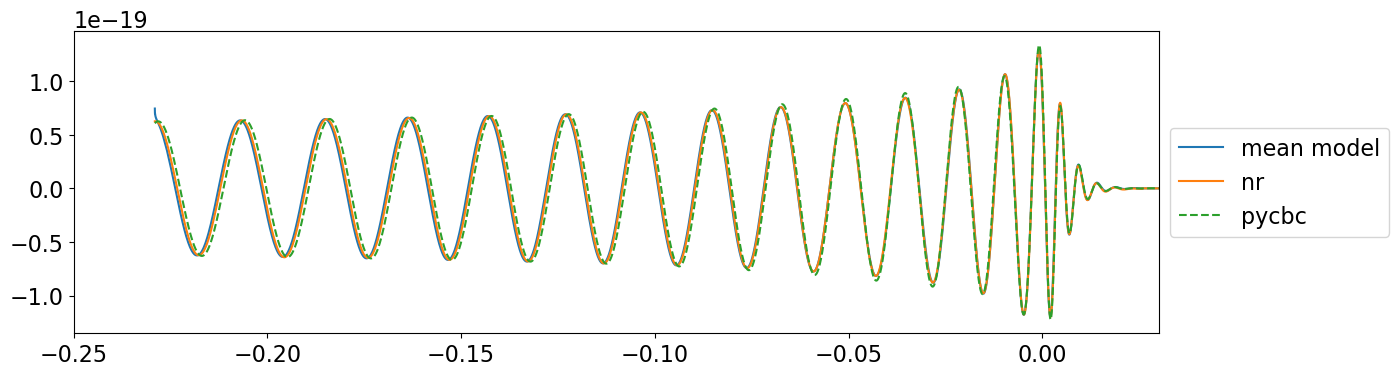

In [606]:
plt.figure(figsize=(14, 4), dpi=100)
plt.plot(h1.sample_times, h1, label='mean model')
plt.plot(h2.sample_times, h2, ls='-', label='nr')
plt.plot(h3.sample_times, h3, ls='--', label='pycbc')
plt.xlim(-0.25, 0.03)
# plt.xlim(-0.1, 0.03)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [607]:
compute_match(hp, hp_nr, 60)

0.988341499202865

In [608]:
compute_match(hm_p, hp_nr, 60)

0.999604259067887

In [609]:
compute_match(hm_p, hp, 60)

0.9877835865827906

In [610]:
ms = [compute_match(hm_p, hs_p_, 60) for hs_p_ in hs_p]
ms = np.array(ms)

In [611]:
ms_nr = [compute_match(hp_nr, hs_p_, 60) for hs_p_ in hs_p]
ms_nr = np.array(ms_nr)

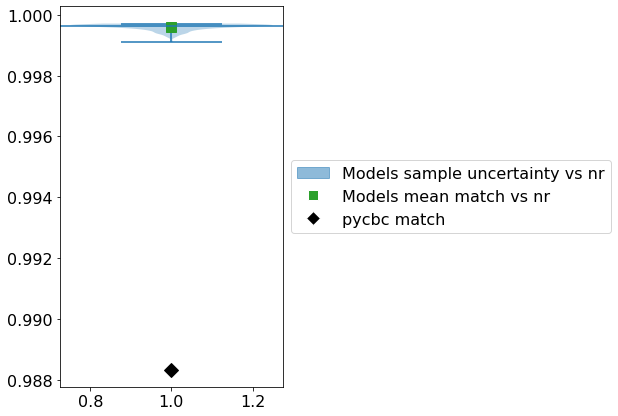

In [612]:
plt.figure(figsize=(4, 7))
plt.violinplot([ms_nr], [1]) # the actual uncertainty in the model
# plt.violinplot([ms], [1]) # the model's own estimate for uncertainty
plt.plot([1], [compute_match(hm_p, hp_nr, 60)], '', marker='s', markersize=10, c='C2', zorder=2) # match of mean model vs NR
plt.plot([1], [compute_match(hp, hp_nr, 60)], '', marker='D', markersize=10, c='k') # match of pycbc vs NR
# plt.yscale('log')

# https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
patches = [
    mpatches.Patch(color='C0', alpha=0.5),
    # mpatches.Patch(color='C1', alpha=0.5),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='C2', markersize=10),
    Line2D([0], [0], marker='D', color='w', markerfacecolor='k', markersize=10),
]
labels = [
    'Models sample uncertainty vs nr',
    # 'Models self uncertainty estimate',
    'Models mean match vs nr',
    'pycbc match',
]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1, 0.5))


# plt.axhline(np.median(ms))
plt.axhline(np.median(ms_nr))

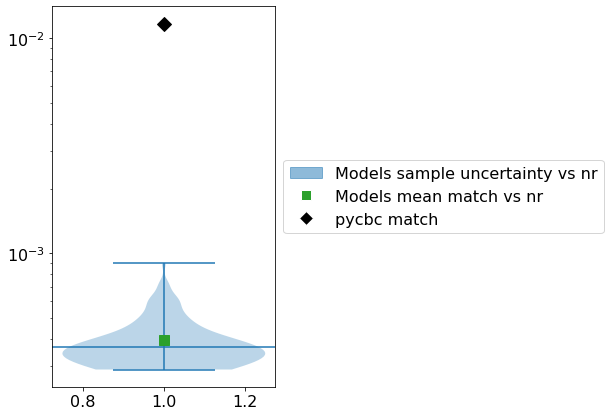

In [613]:
plt.figure(figsize=(4, 7))
plt.violinplot([1-ms_nr], [1]) # the actual uncertainty in the model
# plt.violinplot([ms], [1]) # the model's own estimate for uncertainty
plt.plot([1], [1-compute_match(hm_p, hp_nr, 60)], '', marker='s', markersize=10, c='C2', zorder=2) # match of mean model vs NR
plt.plot([1], [1-compute_match(hp, hp_nr, 60)], '', marker='D', markersize=10, c='k') # match of pycbc vs NR
plt.yscale('log')

# https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
patches = [
    mpatches.Patch(color='C0', alpha=0.5),
    # mpatches.Patch(color='C1', alpha=0.5),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='C2', markersize=10),
    Line2D([0], [0], marker='D', color='w', markerfacecolor='k', markersize=10),
]
labels = [
    'Models sample uncertainty vs nr',
    # 'Models self uncertainty estimate',
    'Models mean match vs nr',
    'pycbc match',
]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1, 0.5))


# plt.axhline(np.median(ms))
plt.axhline(np.median(1-ms_nr))

# check match calculation using nr_hdf5

In [614]:
!ls /Users/sebastian.khan/personal/data/

NRSur7dq4.h5                    SXS_BBH_0180_Res4.h5
SXS_BBH_0107_Res3.h5            SXS_BBH_0303_Res3.h5
SXS_BBH_0107_Res4.h5            SXS_BBH_0303_Res4.h5
SXS_BBH_0107_Res5.h5            SXS_BBH_0303_Res5.h5
SXS_BBH_0167_Res3.h5            bam_dec_2022
SXS_BBH_0167_Res5.h5            gtech_dec_2022
SXS_BBH_0169_Res3.h5            non_spinning_catalogue_dec_2022
SXS_BBH_0169_Res4.h5            q18a0a0c025_144-22-hybrid.h5
SXS_BBH_0169_Res5.h5            rit_dec_2022
SXS_BBH_0180_Res2.h5            sxs_dec_2022
SXS_BBH_0180_Res3.h5


In [615]:
"/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5"

'/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5'

In [616]:
hp_1, hc_2 = pycbc.waveform.get_td_waveform(approximant='SEOBNRv4', mass1=m1, mass2=m2, f_lower=30, delta_t=delta_t)




In [617]:


hp_2, hc_2 = pycbc.waveform.get_td_waveform(
    approximant='NR_hdf5',
    mass1=m1,
    mass2=m2,
    f_lower=30,
    delta_t=delta_t,
    mode_array = [ [2,2], [2,-2] ],
    numrel_data="/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res5.h5"
)




XLAL Error - XLALSimIMRNRWaveformGetModes (/Users/runner/miniforge3/conda-bld/lalsimulation-split_1655125357599/work/lib/LALSimIMRNRWaveforms.c:692): MASSES (5.684211e+01 and 3.157895e+00) ARE INCONSISTENT WITH THE MASS RATIO OF THE NR SIMULATION (eta=1.600003e-01).

XLAL Error - XLALSimIMRNRWaveformGetModes (/Users/runner/miniforge3/conda-bld/lalsimulation-split_1655125357599/work/lib/LALSimIMRNRWaveforms.c:692): Input domain error
XLAL Error - XLALSimInspiralNRWaveformGetHplusHcross (/Users/runner/miniforge3/conda-bld/lalsimulation-split_1655125357599/work/lib/LALSimIMRNRWaveforms.c:954): Internal function call failed: Input domain error
XLAL Error - XLALSimInspiralChooseTDWaveform (/Users/runner/miniforge3/conda-bld/lalsimulation-split_1655125357599/work/lib/LALSimInspiral.c:1232): Internal function call failed: Input domain error


RuntimeError: Internal function call failed: Input domain error

In [ ]:
compute_match(hp_1, hp_2, 60)

In [ ]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

f_low=35
# f_low = 13.1931356291784123
# sample_rate = 4096


# Generate the two waveforms to compare
hp, hc = get_td_waveform(approximant="NRSur7dq4",
                         mass1=m1,
                         mass2=m2,
                         f_lower=f_low,
                         mode_array = [ [2,2], [2,-2] ],
                         delta_t=delta_t)

# hp, hc = get_td_waveform(approximant="SEOBNRv4",
#                          mass1=m1,
#                          mass2=m2,
#                          # f_lower=f_low/4,
#                          f_lower=f_low,
#                          mode_array = [ [2,2], [2,-2] ],
#                          delta_t=delta_t)


# hp, hc = gen_model(df.iloc[i]['q'], times, m_total, -1)

sp, sc = get_td_waveform(approximant="NR_hdf5",
                         mass1=m1,
                         mass2=m2,
                         f_lower=f_low,
                         mode_array = [ [2,2], [2,-2] ], numrel_data="/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res5.h5",
                         delta_t=delta_t)

# Resize the waveforms to the same length
tlen = max(len(sp), len(hp))
sp.resize(tlen)
hp.resize(tlen)

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / sp.duration
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

# Note: This takes a while the first time as an FFT plan is generated
# subsequent calls are much faster.
m, _ = match(hp, sp, psd=psd, low_frequency_cutoff=35)
print('The match is: {:.5f}'.format(m))

In [ ]:
h1, h2 = pycbc.waveform.utils.coalign_waveforms(hp, sp, low_frequency_cutoff=35)

In [ ]:
pycbc.filter.match(h1, h2, low_frequency_cutoff=35)[0]

In [ ]:
pycbc.filter.overlap(h1, h2, low_frequency_cutoff=35)

In [ ]:
plt.figure(figsize=(14, 4), dpi=100)
plt.plot(h1.sample_times, h1)
plt.plot(h2.sample_times, h2, ls='--')
plt.xlim(-0.25, 0.03)
# plt.xlim(-0.1, 0.03)